In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import sys
sys.path.append('./../code/')
from utilities import massModel
from getData import *
import h5py

In [2]:
# Load inference data, as well as posterior samples and injections
hdata = h5py.File("../data/ar_Xeff_Xp_summary.hdf",'r')
injectionDict = getInjections(sample_limit=50000,reweight=False)
sampleDict = getSamples(sample_limit=3000,bbh_only=True,reweight=False)

# Sets of sample locations at which rates are inferred
Xeffs = hdata['posterior/Xeffs']
Xps = hdata['posterior/Xps']

# Extract injection data
m1_inj = injectionDict['m1']
m2_inj = injectionDict['m2']
z_inj = injectionDict['z']
dVdz_inj = injectionDict['dVdz']
Xeff_inj = injectionDict['Xeff']
Xp_inj = injectionDict['Xp']
inj_prior = injectionDict['p_draw_m1m2z']*injectionDict['p_draw_chiEff_chiP']

Removing  GW170817
Removing  S190425z
Removing  S190426c
Removing  S190814bv
Removing  S190917u
Removing  S200105ae
Removing  S200115j


## Create "observed" and "predicted" catalogs of BBH events

In [3]:
# Number of predicted and observed catalogs to consider
nPops = 1000

# Instantiate arrays to hold collections of effective spin values predicted by the fitted model,
# and "observed" values drawn from reweighted posteriors
observed_Xeffs = np.zeros((nPops,len(sampleDict)))
observed_Xps = np.zeros((nPops,len(sampleDict)))
predicted_Xeffs = np.zeros((nPops,len(sampleDict)))
predicted_Xps = np.zeros((nPops,len(sampleDict)))

# Loop across desired number of catalogs
for i in range(nPops):
    
    # Extract effective spin distribution and mass/mass-ratio/redshift hyperparameters
    f_Xeffs = hdata['posterior/f_Xeffs'][:,i]
    f_Xps = hdata['posterior/f_Xps'][:,i]
    alpha = hdata['posterior/alpha'][i]
    mu_m1 = hdata['posterior/mu_m1'][i]
    sig_m1 = hdata['posterior/sig_m1'][i]
    log_f_peak = hdata['posterior/log_f_peak'][i]
    mMin = hdata['posterior/mMin'][i]
    mMax = hdata['posterior/mMax'][i]
    log_dmMin = hdata['posterior/log_dmMin'][i]
    log_dmMax = hdata['posterior/log_dmMax'][i]
    bq = hdata['posterior/bq'][i]
    kappa = hdata['posterior/kappa'][i]
    
    # Compute proposed population at injection locations
    p_inj_Xeff = np.interp(Xeff_inj,Xeffs,f_Xeffs)
    p_inj_Xp = np.interp(Xp_inj,Xps,f_Xps)
    p_inj_m1 = massModel(m1_inj,alpha,mu_m1,sig_m1,10.**log_f_peak,mMax,mMin,10.**log_dmMax,10.**log_dmMin)
    p_inj_m2 = (1.+bq)*m2_inj**bq/(m1_inj**(1.+bq) - 2.**(1.+bq))
    p_inj_m2[m2_inj<2] = 0
    p_inj_z = dVdz_inj*(1.+z_inj)**(kappa-1)
    
    # Randomly draw injections from proposed population
    draw_probs = np.array((p_inj_m1*p_inj_m2*p_inj_z*p_inj_Xeff*p_inj_Xp/inj_prior))
    draw_probs /= draw_probs.sum()
    predicted_ind = np.random.choice(np.arange(draw_probs.size),size=len(sampleDict),p=draw_probs,replace=True)
    predicted_Xeffs[i,:] = Xeff_inj[predicted_ind]
    predicted_Xps[i,:] = Xp_inj[predicted_ind]
    
    # Now loop across events
    for ii,event in enumerate(sampleDict):
        
        # Read out parameters
        m1 = sampleDict[event]['m1']
        m2 = sampleDict[event]['m2']
        z = sampleDict[event]['z']
        dVdz = sampleDict[event]['dVc_dz']
        Xeff = sampleDict[event]['Xeff']
        Xp = sampleDict[event]['Xp']
        z_prior = sampleDict[event]['z_prior']
        spin_prior = sampleDict[event]['joint_priors']
        
        # Construct weights to move to new proposed population
        p_Xeff = np.interp(Xeff,Xeffs,f_Xeffs)
        p_Xp = np.interp(Xp,Xps,f_Xps)
        p_m1 = massModel(m1,alpha,mu_m1,sig_m1,10.**log_f_peak,mMax,mMin,10.**log_dmMax,10.**log_dmMin)
        p_m2 = (1.+bq)*m2**bq/(m1**(1.+bq) - 2.**(1.+bq))
        p_m2[m2<2] = 0
        p_z = dVdz*(1.+z)**(kappa-1)
        
        # Randomly draw from reweighted posterior
        draw_probs = np.array((p_m1*p_m2*p_z*p_Xeff*p_Xp/(z_prior*spin_prior)))
        draw_probs /= draw_probs.sum()
        observed_ind = np.random.choice(np.arange(draw_probs.size),p=draw_probs)
        observed_Xeffs[i,ii] = Xeff[observed_ind]
        observed_Xps[i,ii] = Xp[observed_ind]

## Compare CDFs of predicted and observed catalogs

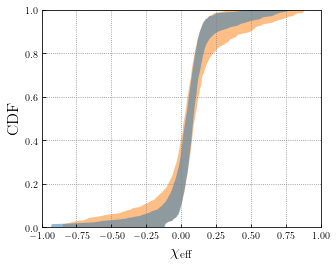

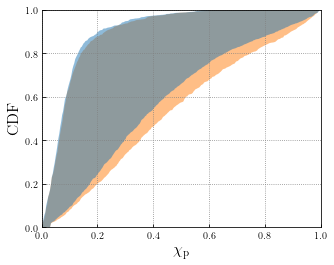

In [4]:
# Define a regular grid
Xeff_grid = np.linspace(-1,1,300)
Xp_grid = np.linspace(0,1,300)

# Instantiate arrays to hold cdfs over the above grid
observed_Xeff_cdf = np.zeros((nPops,Xeff_grid.size))
observed_Xp_cdf = np.zeros((nPops,Xp_grid.size))
predicted_Xeff_cdf = np.zeros((nPops,Xeff_grid.size))
predicted_Xp_cdf = np.zeros((nPops,Xp_grid.size))

# For each of our catalogs, compute CDFs
for i in range(nPops):
    
    Xeff_cdf_vals = np.cumsum(np.ones(len(sampleDict)))/len(sampleDict)
    observed_Xeff_cdf[i,:] = np.interp(Xeff_grid,np.sort(observed_Xeffs[i,:]),Xeff_cdf_vals,left=0)
    
    Xp_cdf_vals = np.cumsum(np.ones(len(sampleDict)))/len(sampleDict)
    observed_Xp_cdf[i,:] = np.interp(Xp_grid,np.sort(observed_Xps[i,:]),Xp_cdf_vals,left=0)
    
    Xeff_cdf_vals = np.cumsum(np.ones(len(sampleDict)))/len(sampleDict)
    predicted_Xeff_cdf[i,:] = np.interp(Xeff_grid,np.sort(predicted_Xeffs[i,:]),Xeff_cdf_vals,left=0)
    
    Xp_cdf_vals = np.cumsum(np.ones(len(sampleDict)))/len(sampleDict)
    predicted_Xp_cdf[i,:] = np.interp(Xp_grid,np.sort(predicted_Xps[i,:]),Xp_cdf_vals,left=0)
    

# Plot!
fig,ax = plt.subplots(figsize=(5,4))
ax.fill_between(Xeff_grid,
                np.quantile(observed_Xeff_cdf,0.05,axis=0),
                np.quantile(observed_Xeff_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(Xeff_grid,
                np.quantile(predicted_Xeff_cdf,0.05,axis=0),
                np.quantile(predicted_Xeff_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

fig,ax = plt.subplots(figsize=(5,4))
ax.fill_between(Xp_grid,
                np.quantile(observed_Xp_cdf,0.05,axis=0),
                np.quantile(observed_Xp_cdf,0.95,axis=0),
                alpha=0.5
               )
ax.fill_between(Xp_grid,
                np.quantile(predicted_Xp_cdf,0.05,axis=0),
                np.quantile(predicted_Xp_cdf,0.95,axis=0),
                zorder=-1,alpha=0.5
               )
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel('CDF',fontsize=16)
plt.show()

## Make predictive check figure

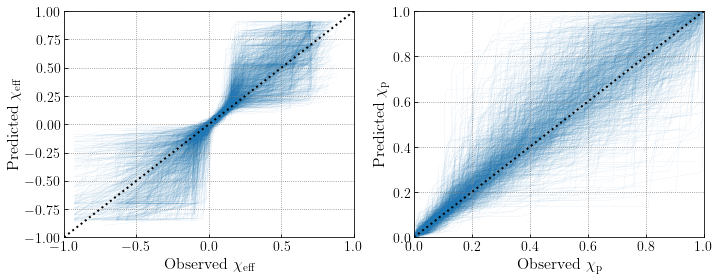

In [5]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    ax.plot(np.sort(observed_Xeffs[i,:]),
            np.sort(predicted_Xeffs[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1
           )
    
ax.plot([-1,1],[-1,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $\chi_\mathrm{eff}$',fontsize=16)
ax.set_ylabel(r'Predicted $\chi_\mathrm{eff}$',fontsize=16)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

ax = fig.add_subplot(122)
ax.set_rasterization_zorder(2)
for i in range(nPops):
    
    ax.plot(np.sort(observed_Xps[i,:]),
            np.sort(predicted_Xps[i,:]),
            color='#1f78b4',alpha=0.2,lw=0.2,zorder=1
           )
    
ax.plot([0,1],[0,1],color='black',ls=':',lw=2)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'Observed $\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel(r'Predicted $\chi_\mathrm{p}$',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('figure_23.pdf',bbox_inches='tight',dpi=200)
plt.show()

## Finally, quantify expected detections in the tails

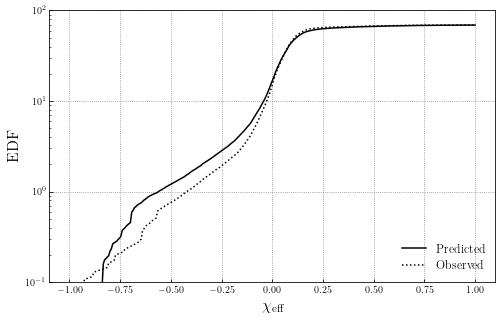

-0.3459701414150436


In [6]:
# Plot the EDF of effective inspiral spins, integrating from left to right
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(Xeff_grid,np.mean(predicted_Xeff_cdf,axis=0)*69,color='black',label='Predicted')
ax.plot(Xeff_grid,np.mean(observed_Xeff_cdf,axis=0)*69,color='black',ls=':',label='Observed')
ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=16)
ax.set_ylabel('EDF',fontsize=16)
ax.legend(loc='lower right',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,1e2)
plt.show()

print(np.interp(2.,np.mean(predicted_Xeff_cdf,axis=0)*69,Xeff_grid))

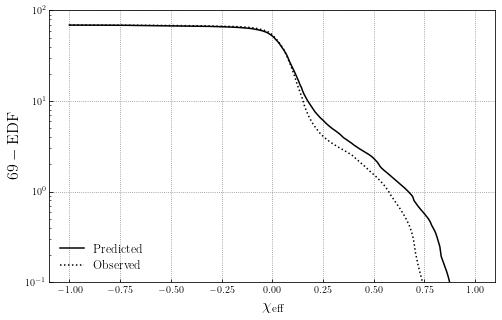

0.5254921462820031


In [7]:
# ...and also integrating from right to left
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(Xeff_grid,69-np.mean(predicted_Xeff_cdf,axis=0)*69,color='black',label='Predicted')
ax.plot(Xeff_grid,69-np.mean(observed_Xeff_cdf,axis=0)*69,color='black',ls=':',label='Observed')
ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=16)
ax.set_ylabel('$69-\mathrm{EDF}$',fontsize=16)
ax.legend(loc='lower left',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,1e2)
plt.show()

print(np.interp(2.,(69-np.mean(predicted_Xeff_cdf,axis=0)*69)[::-1],Xeff_grid[::-1]))

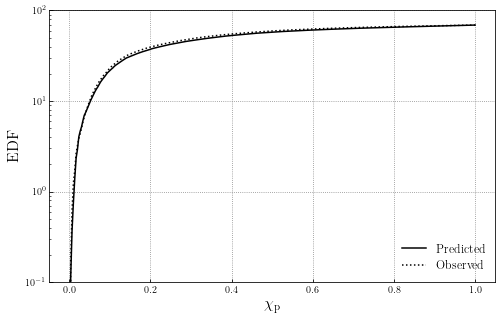

0.015532996879974562


In [8]:
# EDF of precessing spins, integrating left to right
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(Xp_grid,np.mean(predicted_Xp_cdf,axis=0)*69,color='black',label='Predicted')
ax.plot(Xp_grid,np.mean(observed_Xp_cdf,axis=0)*69,color='black',ls=':',label='Observed')
ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel('EDF',fontsize=16)
ax.legend(loc='lower right',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,1e2)
plt.show()

print(np.interp(2.,np.mean(predicted_Xp_cdf,axis=0)*69,Xp_grid))

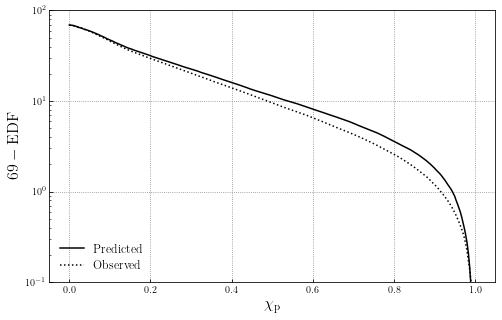

0.8903083084883103


In [9]:
# ...and right to left
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(Xp_grid,69-np.mean(predicted_Xp_cdf,axis=0)*69,color='black',label='Predicted')
ax.plot(Xp_grid,69-np.mean(observed_Xp_cdf,axis=0)*69,color='black',ls=':',label='Observed')
ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel('$69-\mathrm{EDF}$',fontsize=16)
ax.legend(loc='lower left',frameon=False)
ax.set_yscale('log')
ax.set_ylim(1e-1,1e2)
plt.show()

print(np.interp(2.,(69-np.mean(predicted_Xp_cdf,axis=0)*69)[::-1],Xp_grid[::-1]))

In [10]:
# Save macros
with open('./../macros/effective_spin_tails.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\EffectiveSpinTailLowTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,np.mean(predicted_Xeff_cdf,axis=0)*69,Xeff_grid)
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\EffectiveSpinTailLowFour}}{{{0:.2f}}}".format(\
        np.interp(4.,np.mean(predicted_Xeff_cdf,axis=0)*69,Xeff_grid)
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\EffectiveSpinTailHighTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,(69-np.mean(predicted_Xeff_cdf,axis=0)*69)[::-1],Xeff_grid[::-1])
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\EffectiveSpinTailHighFour}}{{{0:.2f}}}".format(\
        np.interp(4.,(69-np.mean(predicted_Xeff_cdf,axis=0)*69)[::-1],Xeff_grid[::-1])
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\PrecessingSpinTailLowTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,np.mean(predicted_Xp_cdf,axis=0)*69,Xp_grid)
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\PrecessingSpinTailLowFour}}{{{0:.2f}}}".format(\
        np.interp(4.,np.mean(predicted_Xp_cdf,axis=0)*69,Xp_grid)
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\PrecessingSpinTailHighTwo}}{{{0:.2f}}}".format(\
        np.interp(2.,(69-np.mean(predicted_Xp_cdf,axis=0)*69)[::-1],Xp_grid[::-1])
        ))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\PrecessingSpinTailHighFour}}{{{0:.2f}}}".format(\
        np.interp(4.,(69-np.mean(predicted_Xp_cdf,axis=0)*69)[::-1],Xp_grid[::-1])
        ))
    macrofile.write("\n")
    